In [1]:
import os
import pandas as pd
import numpy as np

In [8]:
# reading the dataset
PImPo = pd.read_csv("PImPo.csv",delimiter=";")
PImPo.rename(columns={"Unnamed: 0":"id",1:"country",2:"party",3:"content",4:"target",5:"stance",6: "date"},inplace=True)
PImPo.drop(columns=["id"],inplace=True)
PImPo

,country,party,content,target,stance,date
0,sweden,swe: Green Ecology Party,Vi vill ge människor möjligheten att leva i et...,Integration,FAVOR,200609
1,sweden,swe: Green Ecology Party,och där lika rättigheter för alla är en självk...,Integration,FAVOR,200609
2,sweden,swe: Green Ecology Party,Flyktingpolitiken ska göras human,Immigration,FAVOR,200609
3,sweden,swe: Green Ecology Party,Förslagen i vårt valmanifest grundar sig i en ...,Immigration,FAVOR,200609
4,sweden,swe: Green Ecology Party,"Alla barn har rätt till ett liv i kärlek, resp...",Integration,FAVOR,200609
...,...,...,...,...,...,...
8955,new zealand,nzl: Maori Party,The Office of the Controller and Auditor Gener...,Integration,NONE,200811
8956,new zealand,nzl: Maori Party,"In return, we expect services to meet the need...",Integration,FAVOR,200811
8957,new zealand,nzl: Maori Party,All new citizens to complete a course in the h...,Integration,NONE,201111
8958,new zealand,nzl: Mana Party,"Maori, Pasifika and migrant peoples are dispro...",Integration,FAVOR,201111


In [170]:
# selecting sentences with min length 4
PImPo = PImPo.loc[PImPo["content"].str.split(" ").str.len() > 4]

In [171]:
# use for additional filters
country = "netherlands"
PImPo = PImPo.loc[PImPo["country"]==country].drop(columns=["country"])

if not os.path.exists("./"+country):
    os.mkdir("./"+country)

In [157]:
# no country
country = "all_notShort"
PImPo = PImPo.drop(columns=["country"])

In [172]:
# use for test/train split
from sklearn.model_selection import train_test_split
PImPo_train, PImPo_test = train_test_split(PImPo,test_size=0.2)

In [173]:
PImPo_train.to_csv(country+"/train.csv",index=False, sep=",")
PImPo_test.to_csv(country+"/test.csv",index=False, sep=",")



In [50]:
data = pd.read_json("all/data.json")
# print("train:\n",data.loc[data["split"]=="train"]["stance"].value_counts())
# print("valid:\n",data.loc[data["split"]=="valid"]["stance"].value_counts())
# print("test:\n",data.loc[data["split"]=="test"]["stance"].value_counts())
# data = data.loc[data["stance"]=="FAVOR"]
all_df = [len(data["text"].iloc[i]) for i in np.arange(0,len(data))]

pro_df = data.loc[data["stance"]=="FAVOR",:]
pro_df = [len(pro_df["text"].iloc[i]) for i in np.arange(0,len(pro_df))]

against_df = data.loc[data["stance"]=="AGAINST",:]
against_df = [len(against_df["text"].iloc[i]) for i in np.arange(0,len(against_df))]

none_df = data.loc[data["stance"]=="NONE",:]
none_df = [len(none_df["text"].iloc[i]) for i in np.arange(0,len(none_df))]

# Visualization

In [51]:

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x = all_df,
        opacity=0.75,
        name="ALL"
    )
)
fig.add_trace(
    go.Histogram(
        x = pro_df,
        opacity=0.75,
        name="FAVOR"
    )
)
fig.add_trace(
    go.Histogram(
        x = against_df,
        opacity=0.75,
        name="AGAINST"
    )
)
fig.add_trace(
    go.Histogram(
        x = none_df,
        marker_color='#330C73',
        opacity=0.75,
        name="NONE"
    )
)

fig.update_layout(
    xaxis = dict(
        tick0 = 0,
        dtick = 4
    ),
)

fig.update_layout(
    barmode='overlay',
    # title_text = "hist",
    xaxis_title_text='quasi-sentence length', # xaxis label
    yaxis_title_text='count', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
)

fig.write_image("dist.png")

In [52]:
# count ratio calculations
def count_result_ratio(df):
    counts = df.stance.value_counts(normalize=False)
    counts['total'] = df.shape[0]
    return counts

# groups by the key, calculates the ratio, and the plots it via barplot
byCountry = PImPo.groupby("country").apply(count_result_ratio).unstack()
byCountry.reset_index(inplace=True)
byCountry

,country,AGAINST,FAVOR,NONE,total
0,australia,44,95,21,160
1,austria,428,433,137,998
2,canada,18,55,27,100
3,denmank,198,284,121,603
4,finland,95,178,11,284
5,germany,162,1647,137,1946
6,ireland,43,145,40,228
7,netherlands,558,670,155,1383
8,new zealand,3,6,7,16
9,norway,283,990,56,1329


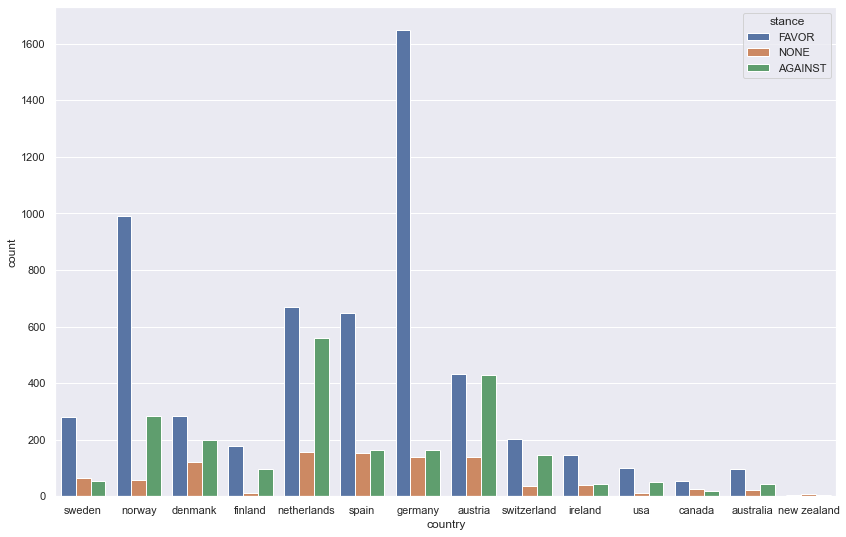

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(14,9)})
ax = sns.countplot(x="country", hue="stance", data=PImPo)
fig = ax.get_figure()
fig.savefig("stance-dist.png")

In [10]:

PImPo.loc[:,'date'] = pd.to_datetime(PImPo['date'], format='%Y%m')
PImPo.set_index('date',inplace=True)

In [11]:
PImPo.loc[PImPo['stance']=='FAVOR','stance'] = 1
PImPo.loc[PImPo['stance']=='NONE','stance'] = 0
PImPo.loc[PImPo['stance']=='AGAINST','stance'] = -1

/var/folders/fy/mftn1wv973vbrftrq9npqbfh0000gn/T/ipykernel_18079/584097333.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


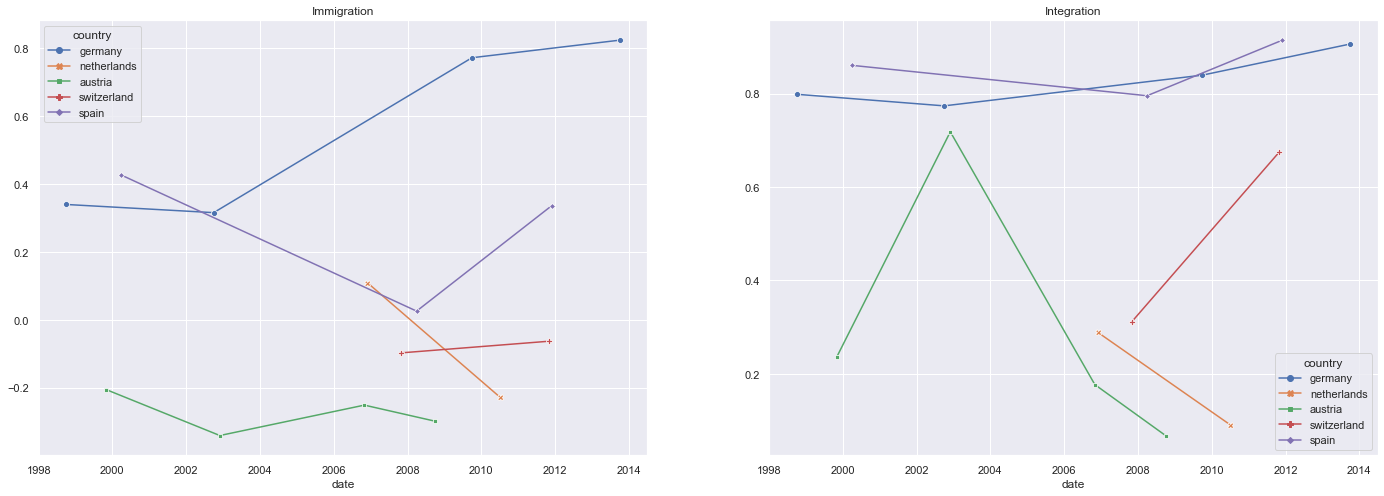

In [13]:
PImPoImmg = PImPo.loc[PImPo['target']=='Immigration']
PImPoIntg = PImPo.loc[PImPo['target']=='Integration']
# generating statistics, for each test group
def date_statistics(df):
    if (df.shape[0] > 0):
        return pd.Series({'values': df.sum()/df.shape[0]})
    else:
        return np.NaN


PImPoImmg = PImPoImmg.groupby('country')['stance'].resample('M').apply(date_statistics).unstack()
PImPoIntg = PImPoIntg.groupby('country')['stance'].resample('M').apply(date_statistics).unstack()

sns.set(rc={'figure.figsize':(24,8)})
fig, ax =plt.subplots(1,2)
sns.lineplot(data=PImPoImmg.T.loc[:,('germany','netherlands','austria','switzerland','spain')], markers=True, dashes=False, ax=ax[0]).set_title("Immigration")
sns.lineplot(data=PImPoIntg.T.loc[:,('germany','netherlands','austria','switzerland','spain')], markers=True, dashes=False, ax=ax[1]).set_title("Integration")
fig.show()
fig.savefig("stance.png")

In [40]:
tmp = pd.DataFrame(PImPo.loc[PImPo['country']=='netherlands']['party'].value_counts())

import plotly.express as px

df = px.data.gapminder().query("continent == 'Asia'")
fig = px.pie(tmp, values='party', names=tmp.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()
fig.write_image('pichart.png')